In [141]:
!pip install pydot
!pip install tensorflow-macos
!pip install tensorflow-metal
!pip install tensorflow-deps

ERROR: Could not find a version that satisfies the requirement tensorflow-deps (from versions: none)
ERROR: No matching distribution found for tensorflow-deps


In [2]:
import sys
import tensorflow as tf
import platform

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import pydot
from keras.utils import plot_model
from keras.utils import image_dataset_from_directory
from keras import layers


In [4]:
image_size = (180, 180)
batch_size = 128
data_train, data_val = image_dataset_from_directory('archive/images/images', labels ='inferred',label_mode = "categorical", subset = 'both', validation_split = 0.3, seed =1300, image_size = image_size, batch_size= batch_size)


Found 15000 files belonging to 30 classes.
Using 10500 files for training.
Using 4500 files for validation.


2024-11-11 19:49:22.511545: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-11-11 19:49:22.511564: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-11 19:49:22.511571: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-11 19:49:22.511605: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-11 19:49:22.511620: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Visualize first 9 images

In [70]:
data_train.class_names

['aerosol_cans',
 'aluminum_food_cans',
 'aluminum_soda_cans',
 'cardboard_boxes',
 'cardboard_packaging',
 'clothing',
 'coffee_grounds',
 'disposable_plastic_cutlery',
 'eggshells',
 'food_waste',
 'glass_beverage_bottles',
 'glass_cosmetic_containers',
 'glass_food_jars',
 'magazines',
 'newspaper',
 'office_paper',
 'paper_cups',
 'plastic_cup_lids',
 'plastic_detergent_bottles',
 'plastic_food_containers',
 'plastic_shopping_bags',
 'plastic_soda_bottles',
 'plastic_straws',
 'plastic_trash_bags',
 'plastic_water_bottles',
 'shoes',
 'steel_food_cans',
 'styrofoam_cups',
 'styrofoam_food_containers',
 'tea_bags']

2024-11-12 12:25:56.065787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


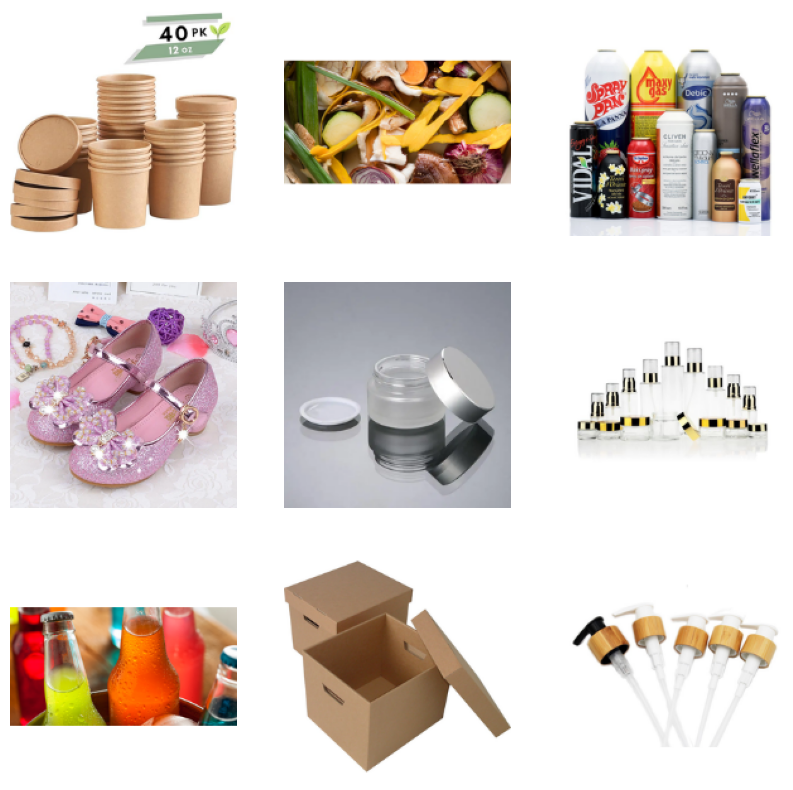

In [72]:
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(4):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        #plt.title(data_train.class_names[i])
        plt.axis("off")

## Model from scratch

### Build a model

In [6]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=30)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 180, 180,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 90, 90,    │      3,584 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 90, 90,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 90, 90,    │          0 │ activation[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 90, 90,    │     34,176 │ activation_1[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 90, 90,    │     68,096 │ activation_2[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 45, 45,    │     33,024 │ activation[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 45, 45,    │          0 │ max_pooling2d[0]… │
│                     │ 256)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 45, 45,    │          0 │ add[0][0]         │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 45, 45,    │    133,888 │ activation_3[0][… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │      2,048 │ separable_conv2d

 Total params: 2,760,790 (10.53 MB)

 Trainable params: 2,752,502 (10.50 MB)

 Non-trainable params: 8,288 (32.38 KB)

### Train the model

In [7]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.SGD(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
)
model.fit(
    data_train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=data_val,
)

Epoch 1/25


2024-11-11 19:49:55.716606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


83/83 ━━━━━━━━━━━━━━━━━━━━ 1133s 14s/step - acc: 0.1187 - loss: 3.2355 - val_acc: 0.0336 - val_loss: 3.4019
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1091s 13s/step - acc: 0.2076 - loss: 2.8571 - val_acc: 0.0311 - val_loss: 3.4084
Epoch 3/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1004s 12s/step - acc: 0.2428 - loss: 2.7049 - val_acc: 0.0304 - val_loss: 3.4273
Epoch 4/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1053s 13s/step - acc: 0.2861 - loss: 2.5925 - val_acc: 0.0411 - val_loss: 3.4631
Epoch 5/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1023s 12s/step - acc: 0.2832 - loss: 2.6096 - val_acc: 0.0360 - val_loss: 3.5577
Epoch 6/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1012s 12s/step - acc: 0.3046 - loss: 2.4730 - val_acc: 0.0382 - val_loss: 3.5982
Epoch 7/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 983s 12s/step - acc: 0.3272 - loss: 2.4065 - val_acc: 0.0524 - val_loss: 3.6183
Epoch 8/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1055s 13s/step - acc: 0.3419 - loss: 2.3385 - val_acc: 0.0836 - val_loss: 3.5149
Epoch 9/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1020s 12s/step - acc: 

In [8]:
model.save('classifier_scratch_model.h5')


## Pre-trained models

In [11]:
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Sequential

In [15]:
num_classes = 30
model_RN50 = Sequential()
model_RN50.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))

In [16]:
model_RN50.add(layers.Dense(num_classes, activation='softmax'))

In [17]:
model_RN50.layers[0].trainable = False
model_RN50.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │        61,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,649,182 (90.21 MB)

 Trainable params: 61,470 (240.12 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
model_RN50.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [19]:
 model_RN50.fit(
    data_train,
    epochs=epochs,
    callbacks = callbacks,
    validation_data=data_val,
)

Epoch 1/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - categorical_accuracy: 0.2012 - loss: 3.0558 - val_categorical_accuracy: 0.2009 - val_loss: 2.8333
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - categorical_accuracy: 0.5533 - loss: 1.5765 - val_categorical_accuracy: 0.4429 - val_loss: 1.8584
Epoch 3/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - categorical_accuracy: 0.6287 - loss: 1.2784 - val_categorical_accuracy: 0.5947 - val_loss: 1.3630
Epoch 4/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - categorical_accuracy: 0.6846 - loss: 1.0904 - val_categorical_accuracy: 0.5953 - val_loss: 1.3678
Epoch 5/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - categorical_accuracy: 0.7052 - loss: 1.0052 - val_categorical_accuracy: 0.5436 - val_loss: 1.5796
Epoch 6/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - categorical_accuracy: 0.7110 - loss: 0.9888 - val_categorical_accuracy: 0.5896 - val_loss: 1.3743
Epoch 7/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - categorical_accuracy: 0.7323 - loss: 0.90

### Run inference on new data

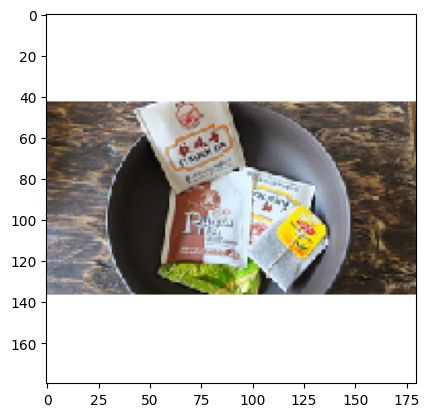

In [96]:
img = keras.utils.load_img("archive/images/images/tea_bags/real_world/image_12.png", target_size=image_size)
plt.imshow(img)

In [97]:
img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)

In [98]:
predictions = model_RN50.predict(img_array)
print(predictions)
#score = float(keras.ops.sigmoid(predictions[0][0]))
predicted_index = np.argmax(predictions)
print("Predicted label: " + data_train.class_names[predicted_index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
[[7.83256954e-04 3.76503146e-03 4.93842317e-03 1.21295797e-02
  2.43005604e-02 2.43151076e-02 8.27556998e-02 4.54902090e-02
  6.50208220e-02 1.03040431e-02 3.48097907e-04 9.91638663e-05
  1.99489703e-04 1.33781889e-02 4.40171771e-02 8.83341942e-04
  6.02824846e-03 1.01592077e-03 3.74860974e-04 1.60311372e-03
  2.78559886e-03 1.04881758e-02 1.61858334e-03 1.26995705e-02
  1.10110128e-02 7.55416183e-03 9.29489732e-03 2.86982441e-03
  2.64116284e-03 5.97286642e-01]]
Predicted label: tea_bags


## Pre-trained ResNet152

In [127]:
from keras.applications import ResNet152
from keras.applications.resnet import preprocess_input

In [132]:
image_size_RN152 = (224,224)
data_train_RN152, data_val_RN152 = image_dataset_from_directory('archive/images/images', labels ='inferred',label_mode = "categorical", 
                                                    subset = 'both', validation_split = 0.3, seed =1300, image_size = image_size_RN152, 
                                                    batch_size= batch_size, color_mode = "rgb")

model_RN152 = Sequential()

model_RN152.add(ResNet152(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))

Found 15000 files belonging to 30 classes.
Using 10500 files for training.
Using 4500 files for validation.


In [133]:
model_RN152.add(layers.Dense(num_classes, activation='softmax'))

model_RN152.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model_RN152.layers[0].trainable = False

In [134]:
fit_RN152 = model_RN152.fit(
    data_train_RN152,
    epochs=epochs,
    validation_data=data_val_RN152,
)

Epoch 1/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 453s 5s/step - categorical_accuracy: 0.4404 - loss: 2.0870 - val_categorical_accuracy: 0.7202 - val_loss: 0.8983
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 394s 5s/step - categorical_accuracy: 0.7806 - loss: 0.7181 - val_categorical_accuracy: 0.7682 - val_loss: 0.7360
Epoch 3/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 401s 5s/step - categorical_accuracy: 0.8487 - loss: 0.5226 - val_categorical_accuracy: 0.7900 - val_loss: 0.6736
Epoch 4/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 390s 5s/step - categorical_accuracy: 0.8760 - loss: 0.4246 - val_categorical_accuracy: 0.8100 - val_loss: 0.6234
Epoch 5/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 392s 5s/step - categorical_accuracy: 0.8889 - loss: 0.3752 - val_categorical_accuracy: 0.8147 - val_loss: 0.6100
Epoch 6/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 391s 5s/step - categorical_accuracy: 0.9083 - loss: 0.3188 - val_categorical_accuracy: 0.8224 - val_loss: 0.5894
Epoch 7/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 390s 5s/step - categorical_accuracy: 0.9144 - loss: 0.28

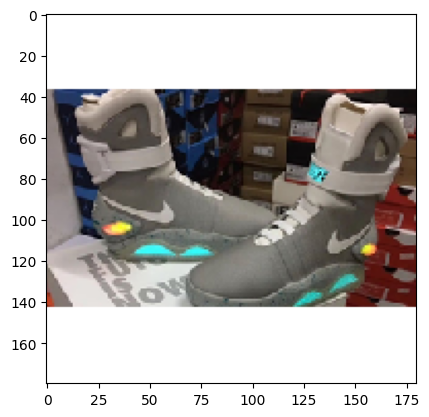

In [157]:
img = keras.utils.load_img("archive/images/images/shoes/real_world/image_35.png", target_size=image_size)
plt.imshow(img)

In [158]:
img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)

In [159]:
predictions_RN152 = model_RN152.predict(img_array)
print(predictions_RN152)
predicted_index_RN152 = np.argmax(predictions_RN152)
print("Predicted label: " + data_train.class_names[predicted_index_RN152])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
[[8.4382727e-08 1.9530299e-11 1.6641316e-08 8.0580939e-08 1.0352818e-07
  1.7280297e-05 6.4493771e-10 1.6474367e-13 9.8990127e-10 1.1737662e-10
  3.6794342e-11 3.1769289e-13 3.7963170e-12 7.2107091e-06 2.0747213e-07
  3.5345672e-06 8.1265072e-10 1.0089802e-10 5.2645323e-13 4.9384212e-11
  3.7394591e-11 1.0294971e-04 1.8667090e-09 9.2342503e-07 5.9825015e-06
  9.9976522e-01 1.2648430e-09 9.6403630e-05 9.8033421e-09 6.6480944e-12]]
Predicted label: shoes
